# パーティクルフィルタによる自己位置推定

In [2]:
import sys
sys.path.append('../src')
import importlib

import worlds
import maps
import numpy as np
import robots
import sensors
import agents
import landmarks
import estimators

def reload():
    importlib.reload(worlds)
    importlib.reload(maps)
    importlib.reload(robots)
    importlib.reload(sensors)
    importlib.reload(agents)
    importlib.reload(estimators)


reload()

<IPython.core.display.Javascript object>


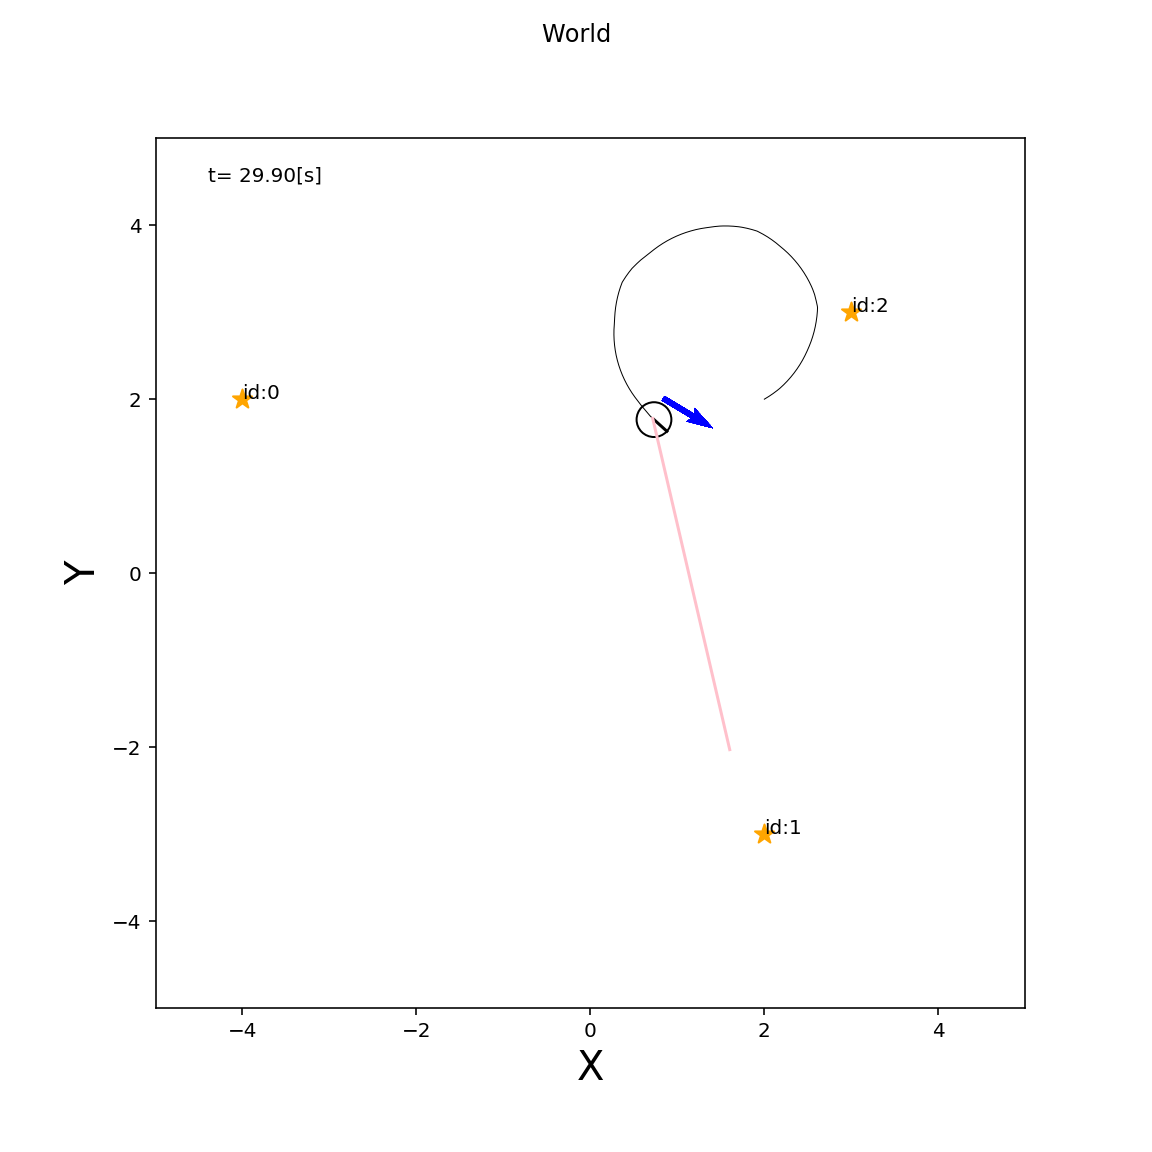

In [4]:
# 手始めにパーティクルを表示
reload()
world = worlds.World(30., 0.1, debuggable=False)
m = maps.Map()
for ln in [(-4., 2.), (2., -3), (3., 3.)]:
    m.append_landmark(landmarks.Point2DLandmark(*ln))
world.append(m)
    
initial_pose = np.array([2., 2., np.pi / 6.]).T
estimator = estimators.Mcl(
    initial_pose, 100,
    motion_noise_stds={'nn':0.00001, 'no': 0.00001, 'on': 0.00001, 'oo': 0.00001})
circling = agents.EstimationAgent(
    0.1, 0.2, 10./180.*np.pi, estimator=estimator)
r = robots.Robot(initial_pose, sensor=sensors.Camera(m), agent=circling)
world.append(r)
world.draw()

パーティクルの更新

状態遷移モデルを作ろう

シミュレータでロボットの挙動の統計をとって，作っていく

ノイズが正規分布に従うと仮定してみる

指数分布に従うノイズを入れたりしているが，まずはこれで

このときの雑音パラメータを

- $\sigma_{\nu \nu}$ : 直進1mで生じる道のりのばらつきのstddev
- $\sigma_{\nu \omega}$ : 回転1radで生じる道のりのばらつきのstddev
- $\sigma_{\omega \nu}$ : 直進1mで生じる回転のばらつきのstddev
- $\sigma_{\omega \omega}$ : 回転1radで生じる回転のばらつきのstddev

$\sigma_{a b}$は，$b$が$a$にあたえるばらつきのstddevを表す

$b$があたえる雑音$\delta_{ab}$は移動量・回転量に比例するので

$$
\delta^{2}_{ab} : \left(\delta^{\prime}_{ab} \Delta t \right)^{2} = 1 : |b| \Delta t \\
\\
\delta^{\prime}_{ab} = \delta_{ab} \sqrt{|b| / \Delta t}
$$

$a$, $b$に$\nu$, $\omega$を代入すると制御指令に加えるべき雑音がわかる

これを${\bf \it u}^{\prime}$とすると

$$
\left(
    \begin{array}{c}
        \nu^{\prime} \\
        \omega^{\prime}
    \end{array}
\right) = \left(
    \begin{array}{c}
        \nu^{\prime} \\
        \omega^{\prime}
    \end{array}
\right) + \left(
    \begin{array}{c}
        \delta_{\nu \nu} \sqrt{|\nu| / \Delta t} + \delta_{\omega \nu} \sqrt{|\omega|  / \Delta t} \\
        \delta_{\omega \nu} \sqrt{|\nu| / \Delta t} + \delta_{\omega \omega} \sqrt{|\omega|  / \Delta t}
\end{array}
\right)
$$

シミュレータでロボットを走らせて，これらの値を計測する

In [6]:
# 実装確認コード
reload()

init_pose = np.array([0., 0., 0.]).T
estimator = estimators.Mcl(
    init_pose, 100, 
    motion_noise_stds={'nn':0.01, 'no': 0.02, 'on': 0.03, 'oo': 0.04})
a = agents.EstimationAgent(0.1, 0.2, 10./180.*np.pi, estimator)
estimator.motion_update(0.2, 10./180.*np.pi, 0.1)
for p in estimator.particles:
    print(p.pose)

[0.02489719 0.0002704  0.02172078]
[0.01734311 0.00015642 0.01803766]
[0.02245476 0.00020985 0.01869081]
[0.02381101 0.00016982 0.0142634 ]
[0.02183773 0.00018207 0.01667444]
[0.02207623 0.00040387 0.0365846 ]
[0.01947321 0.0001291  0.01325884]
[0.02163911 0.0001242  0.01147866]
[0.01685243 0.00018968 0.02250924]
[0.02264633 0.00018707 0.01652034]
[0.02204747 0.00021999 0.01995542]
[0.01977666 0.00012112 0.0122486 ]
[0.01426359 0.00011676 0.01637139]
[1.82183985e-02 1.33658861e-05 1.46729513e-03]
[0.02039816 0.00013191 0.0129332 ]
[0.01686941 0.00018347 0.02175056]
[0.01827076 0.00027841 0.0304737 ]
[1.87335272e-02 7.17033140e-05 7.65504146e-03]
[0.02512799 0.00033277 0.0264848 ]
[0.01778898 0.00020328 0.02285328]
[0.02179627 0.00012665 0.0116207 ]
[0.02019246 0.00029271 0.02898998]
[0.01734809 0.00020571 0.02371396]
[1.60021131e-02 9.21230189e-05 1.15137296e-02]
[0.02066843 0.00018418 0.01782145]
[0.01996505 0.00011548 0.01156765]
[0.02114907 0.00023528 0.02224878]
[0.02249072 0.00030

<IPython.core.display.Javascript object>


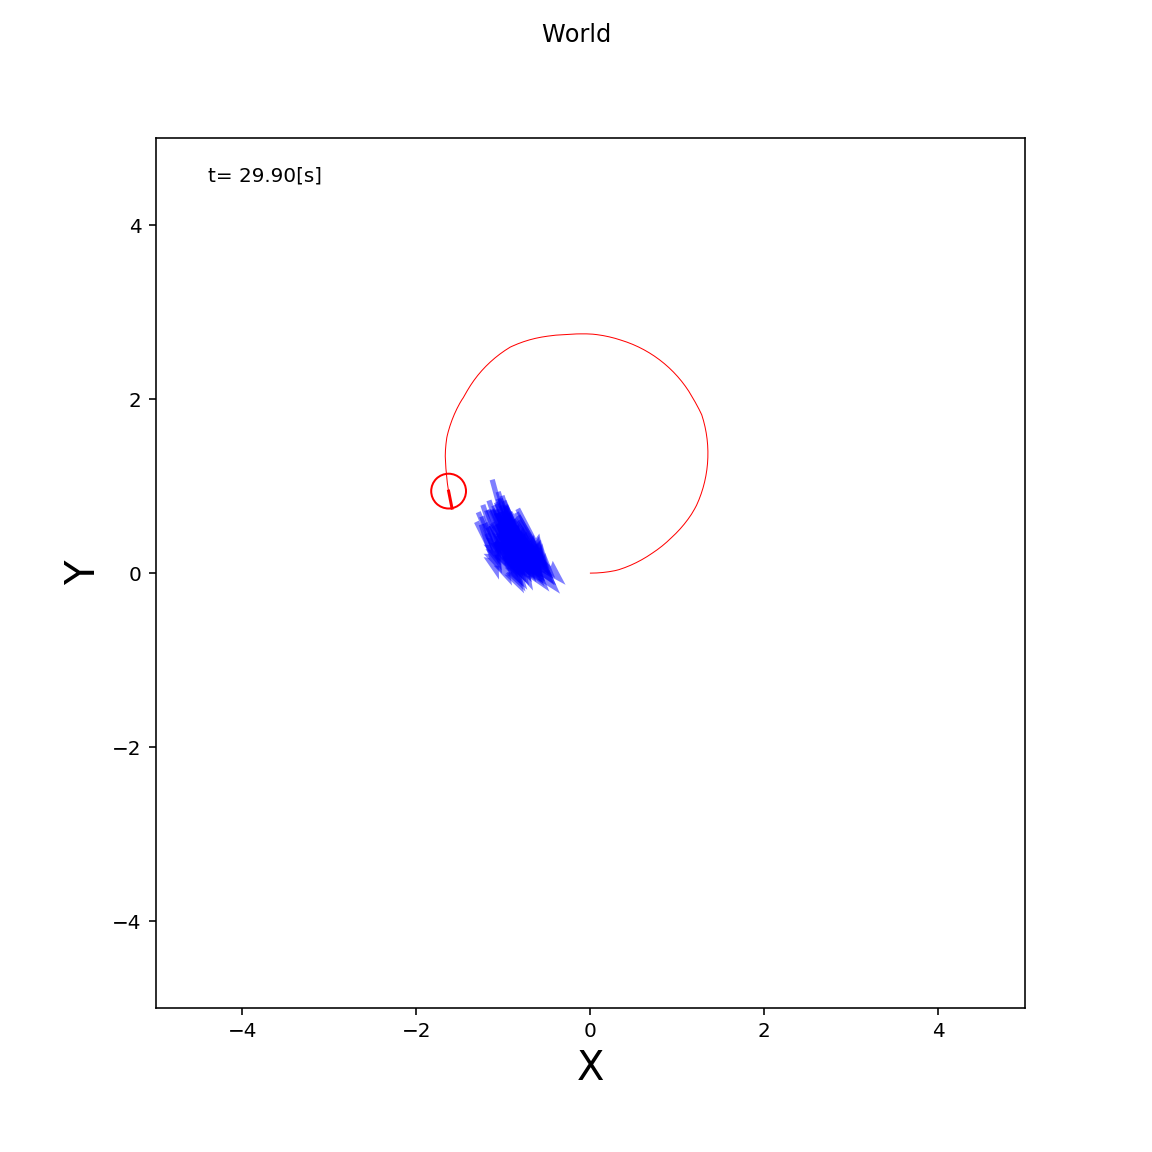

In [7]:
# パーティクルのノイズパラメータを適当に与えてばらつかせてみる
reload()
def trial(motion_noise_stds):
    time_interval = 0.1
    world = worlds.World(30., time_interval)
    
    initial_pose = np.array([0., 0., 0.]).T
    estimator = estimators.Mcl(initial_pose, 100, motion_noise_stds=motion_noise_stds)
    circling = agents.EstimationAgent(
        0.1, 0.2, 10./180.*np.pi, estimator=estimator)
    r = robots.Robot(initial_pose, sensor=None, agent=circling, color='red')
    world.append(r)
    
    world.draw()
    
trial({'nn':0.01, 'no': 0.02, 'on': 0.03, 'oo': 0.04})

<IPython.core.display.Javascript object>


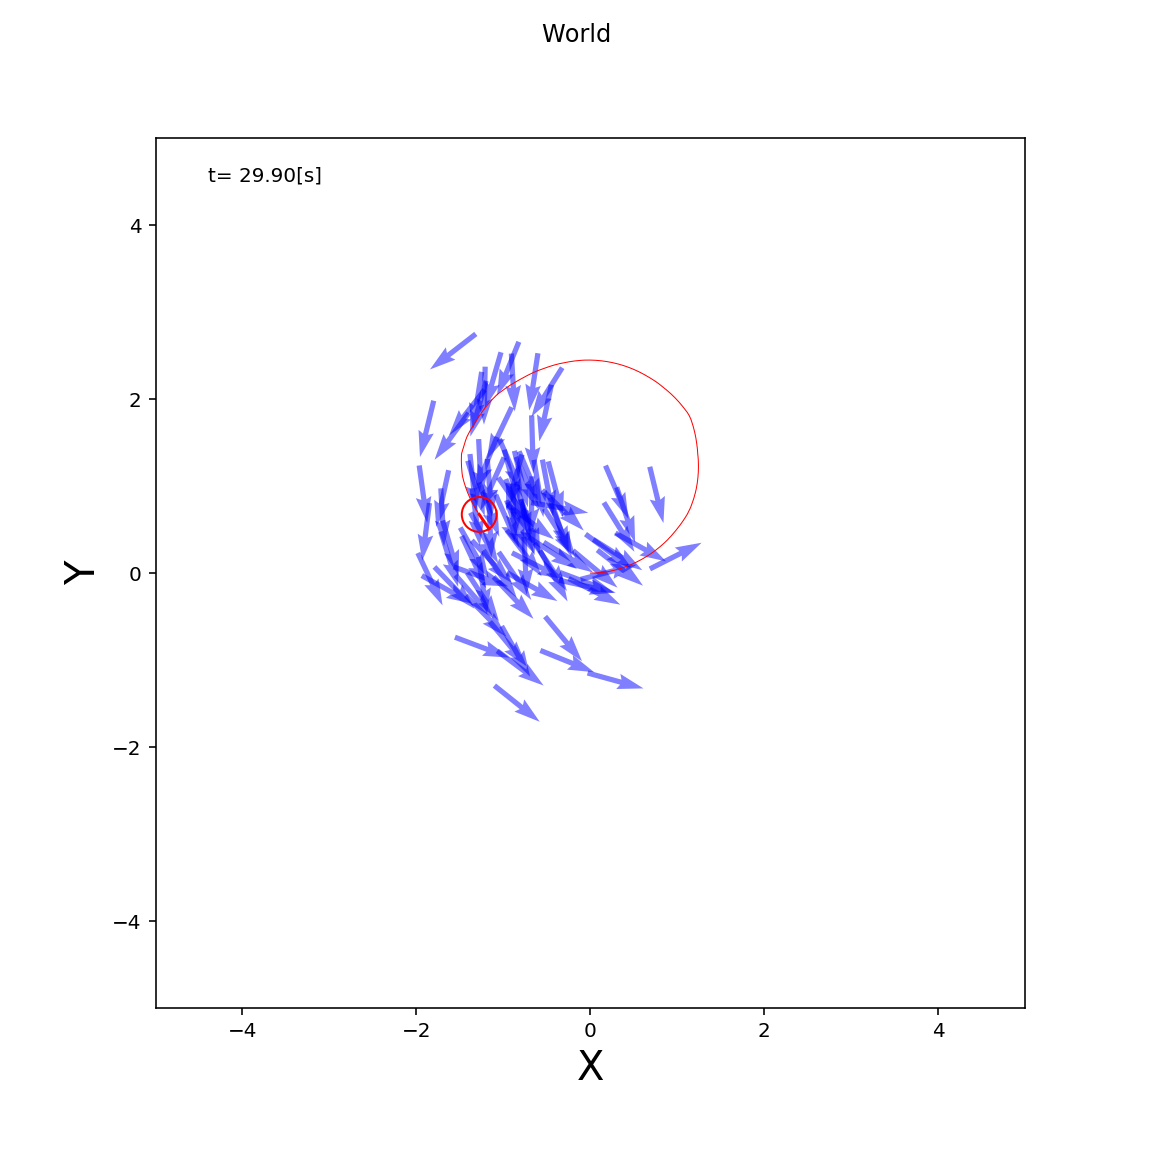

In [8]:
# motion_model_parameterノートブックで求めたパラメータを与えたときのパーティクルの分布
# なんかいい感じに求まらなかったので，原典のパラメータを与えることにした

reload()
trial({'nn':0.19, 'no': 0.0001, 'on': 0.13, 'oo': 0.2})

このときのパーティクルフィルタの分布

$$
P({\bf \it x}^{*} \in \it X) = \int_{x \in X} b_{t}(\bf \it x) d {\bf \it x} \approx \frac{1}{N} \sum_{i=0}^{N-1}\delta({\bf \it x}_{i}^{(i)} \in X)
$$

$\delta (\cdot)$は中身がTrueなら1, Falseなら0を返す関数

X内にあるパーティクルの割合を計算し，

その値を

ロボットの姿勢が$X$ないにある確率とする

<IPython.core.display.Javascript object>


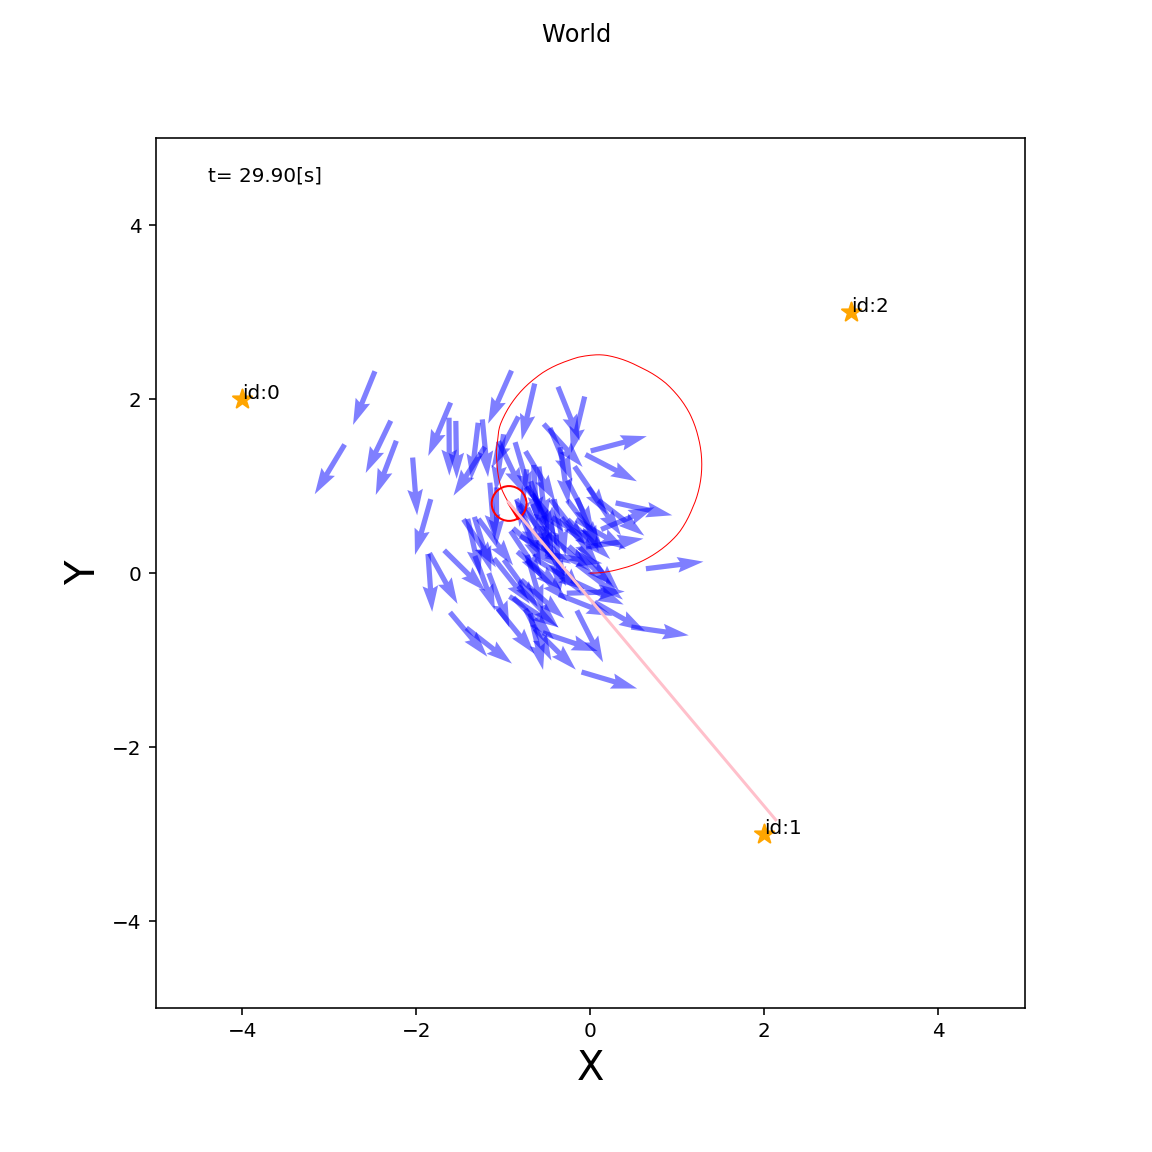

In [3]:
# パーティクルに観測後の結果を反映させていく
reload()

# 検証用の関数
def trial():
    time_interval = 0.1
    world = worlds.World(30., time_interval, debuggable=False)
    
    m = maps.Map()
    for ln in [(-4., 2.), (2., -3.), (3., 3.)]:
        m.append_landmark(landmarks.Point2DLandmark(*ln))
    world.append(m)
    initial_pose = np.array([0., 0., 0.]).T
    estimator = estimators.Mcl(initial_pose, 100)
    a = agents.EstimationAgent(
        time_interval, 0.2, 10./180.*np.pi, estimator=estimator)
    r = robots.Robot(initial_pose, sensor=sensors.Camera(m), agent=a, color='red')
    world.append(r)
    
    world.draw()
    
trial()

## パーティクルの自己位置をセンサ値から

数式はむずいので，

- 実装
- 本読む
- コメントとlatexで補強

という形で進める

尤度関数は別notebook sensor_experiment.ipynbで